## Table of content

| Chapter                                     | Description                                     |
|:--------------------------------------------|:------------------------------------------------|
| [Main goal](#main-goal)                     | Describes the main goal of this notebook        |
| [Data description](#data-description)       | Describes data structure                        |
| [Statistic](#statistic)                     | Shows main characteristics of data              |
| [Plots](#plots)                             | Shows a big part of issues and patterns in data |
| [Preprocessing](#preprocessing)             | Describe the preprocessing process              |
| [Additional features](#additional-features) | Describe features that I would add              |
| [Conclusion](#conclusion)                   | Summarize the whole notebook                    |

## Main goal

The main goal of this notebook is get data understanding, select patterns in the data, overthink preprocessing process and feature engineering, select potential problems and do manual prediction of the data.

## Data description

This dataset provides historical sales data for an e-commerce platform in Russia. It consists of five files containing information on items, categories, shops, and sales transactions from January 2013 to October 2015.

### File Descriptions:

`items.csv`

* `item_name`: `string` - Name of the good.
* `item_id`: `integer` - Primary key, a unique identifier for each item.
* `item_category_id`: `integer` - Foreign key linking to item_categories.csv.

`item_categories.csv`

* `item_category_name`: `string` - Name of the product category.
* `item_category_id`: `integer` - Primary key, a unique identifier for each category.

`shops.csv`

* `shop_name`: `string` - Name of the shop.
* `shop_id`: `integer` - Primary key, a unique identifier for each shop.

`sales_train.csv`

* `date`: `datetime` - Date of purchase in dd.mm.yyyy format.
* `date_block_num`: `integer` - A unique monthly identifier. January 2013 is 0, February 2013 is 1, and so on.
* `shop_id`: `integer` - Foreign key linking to shops.csv.
* `item_id`: `integer` - Foreign key linking to items.csv.
* `item_price`: `float` - The price of the item in Russian Rubles (RUB).
* `item_cnt_day`: `integer` - The number of units of the item sold on a specific day. This value can be negative due to returns.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
item_categories = pd.read_csv("data/item_categories.csv")
items = pd.read_csv("data/items.csv")
sales_train = pd.read_csv("data/sales_train.csv", parse_dates=["date"], date_format="%d.%m.%Y")
sample_submission = pd.read_csv("data/sample_submission.csv")
shops = pd.read_csv("data/shops.csv")
test = pd.read_csv("data/test.csv")

items = items.merge(item_categories, how="left", on="item_category_id", validate="m:1")
sales_train = sales_train.merge(shops, how="left", on="shop_id", validate="m:1")
sales_train = sales_train.merge(items, how="left", on="item_id", validate="m:m")
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,"Москва ТРК ""Атриум""",V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства
2935845,2015-10-09,33,25,7460,299.00,1.0,"Москва ТРК ""Атриум""",V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.00,1.0,"Москва ТРК ""Атриум""",V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.00,1.0,"Москва ТРК ""Атриум""",V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3


In [3]:
df_train = sales_train

In [4]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'shop_name', 'item_name', 'item_category_id',
       'item_category_name'],
      dtype='object')

## Statistic

In this chapter we'll look at some statistic measures like math moments. It will help us find out some issues in the data.

In [5]:
df_train[["item_cnt_day", "item_price"]].describe().round(3)

,item_cnt_day,item_price
count,2935849.000,2935849.000
mean,1.243,890.853
std,2.619,1729.800
min,-22.000,-1.000
25%,1.000,249.000
50%,1.000,399.000
75%,1.000,999.000
max,2169.000,307980.000


In [6]:
print(f"Skewness: {df_train['item_cnt_day'].skew()}")
print(f"Kurtosis: {df_train['item_cnt_day'].kurt()}")

Skewness: 272.83316168440535
Kurtosis: 177478.0987736997


1. As we can see above, data has incorrect values (like negative price).
2. 1, 2 and 3 quartile are equal, it means that people very often by only one unique thing at time.
3. Skewness shows symmetric of distribution, in our case Skewness = 272.83, it means that sales distribution has very heavy/long right tail, and it's means there are sales with a lot of sold item at one time (maximum sold item at a time is 2169).
4. Kurtosis shows tailedness of distribution, High kurtosis (normal kurtosis is equal 0) means that data has long tail/tails, long tail/tails mean a lot of potential outliers.

In summary data has long and heavy right tail. It shows that there are a few transactions with very big amount of sold items.

### Negative sales (returns)

In [7]:
returns = -df_train[df_train['item_cnt_day'] < 0]['item_cnt_day'].sum()

print(f"Returns: {returns} / {returns / df_train['item_cnt_day'].sum():.2%}")

Returns: 7541.0 / 0.21%


A small part (0.21% of all sold items) of sold items returned, It's clear to drop these records and records where these items were sold, because these data useless and harmful for amount prediction task.

## Plots

Plots help us to see data's distribution, select different patterns in data, and select potential outliers.

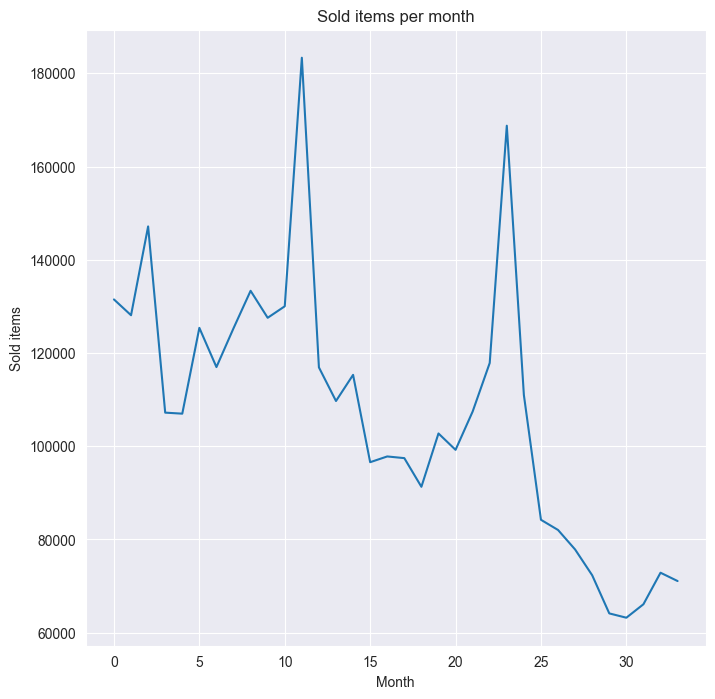

In [8]:
monthly_sales = df_train.groupby(["date_block_num"])["item_cnt_day"].sum().reset_index()
plt.figure(figsize=(8,8))
plt.title("Sold items per month")
plt.xlabel("Month")
plt.ylabel("Sold items")
sns.lineplot(data=monthly_sales, x="date_block_num", y="item_cnt_day")
plt.show()

1. It's clear that sales have downtrend, it happens because distribution of content in internet become more popular and crowd out distribution through physical media.
2. There are 3 peaks and each peak occurs during new year season, if we look at goods and its categories it will become clear that people byu gifts and other things for holidays, and it's clear seasonality in every 12 month.

In [9]:
def get_shops_with_time_threshold(threshold: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Finds shops with more than threshold history of sales.
    Args:
        threshold (int): amount of month that shops must sale
    Returns:
        pd.DataFrame: shop's id that sale more than threshold
        pd.DataFrame: shop's id that sale less than threshold
    """
    df_start_month = df_train.groupby("shop_id")["date_block_num"].min()
    df_end_month = df_train.groupby("shop_id")["date_block_num"].max()

    df_month_amount = df_end_month - df_start_month
    df_older_mask = df_month_amount >= threshold
    df_shop_ids = df_train["shop_id"].unique()
    df_shop_ids.sort()
    df_old_shops = df_shop_ids[df_older_mask]
    df_young_shops = df_shop_ids[~df_older_mask]

    return df_old_shops, df_young_shops


old shops: 42; young shops: 18


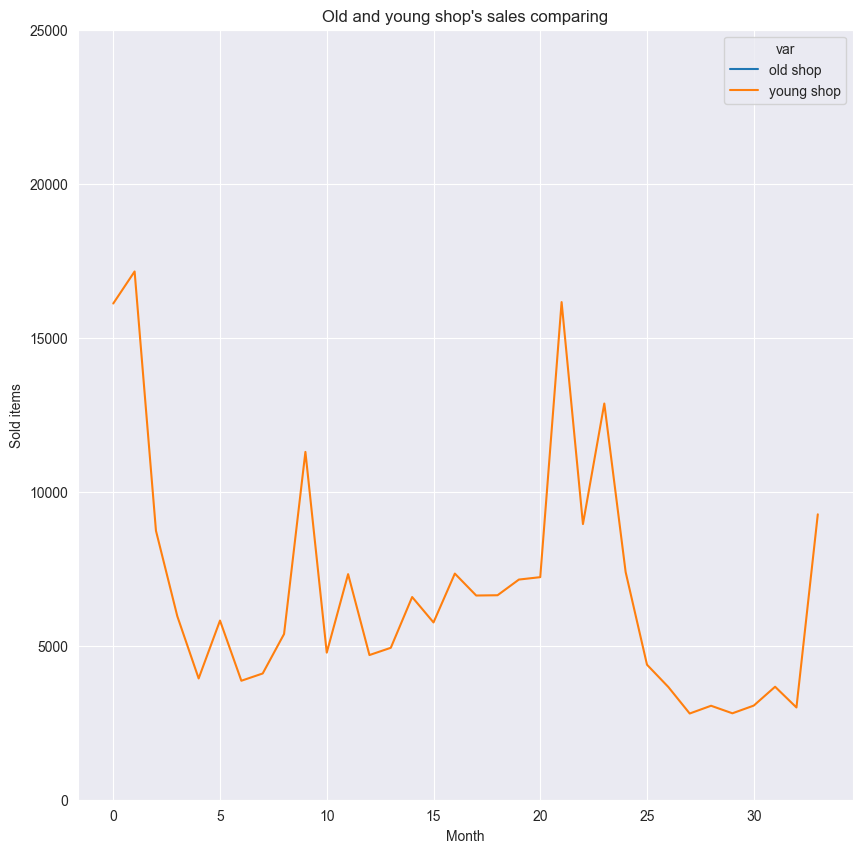

In [11]:
df_old_shops, df_young_shops = get_shops_with_time_threshold(25)

print(f"old shops: {df_old_shops.shape[0]}; young shops: {df_young_shops.shape[0]}")

df_old_monthly_sales = df_train[df_train["shop_id"].isin(df_old_shops)].groupby("date_block_num")["item_cnt_day"].sum().reset_index()
df_new_monthly_sales = df_train[df_train["shop_id"].isin(df_young_shops)].groupby("date_block_num")["item_cnt_day"].sum().reset_index()

df_old_monthly_sales["var"] = pd.Series(["old shop"] * len(df_old_monthly_sales))
df_new_monthly_sales["var"] = pd.Series(["young shop"] * len(df_new_monthly_sales))

plt.figure(figsize=(10,10))
plt.title("Old and young shop's sales comparing")
plt.xlabel("Month")
plt.ylabel("Sold items")
plt.ylim(0, 25000)
sns.lineplot(pd.concat([df_old_monthly_sales, df_new_monthly_sales]), x="date_block_num", y="item_cnt_day", hue="var")
plt.show()

The net of shops mostly consists of old shops (more than 25 month of sales), and old shops have more sales than young, because old shops have impact on overall interval, while young only for a some part. Let's check why young shops have closed.

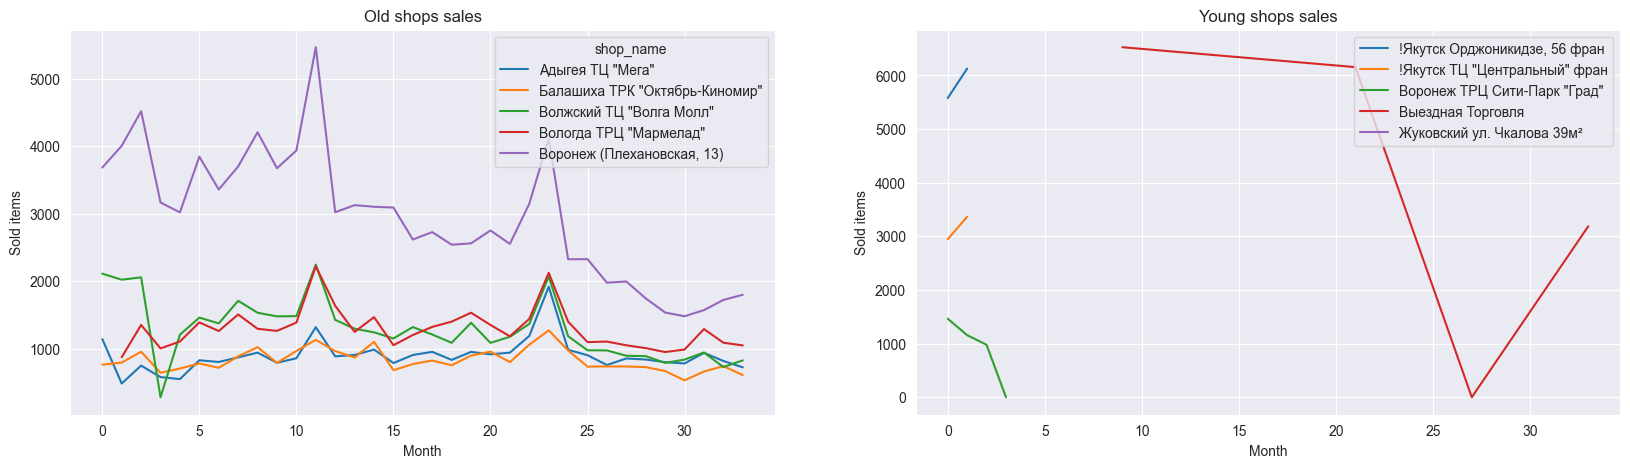

In [11]:
df_5_old_shops = df_train[df_train["shop_id"].isin(df_old_shops[:5])]
df_5_young_shops = df_train[df_train["shop_id"].isin(df_young_shops[:5])]

df_5_old_monthly_sales = df_5_old_shops.groupby(["shop_name", "date_block_num"])["item_cnt_day"].sum().reset_index()
df_5_young_monthly_sales = df_5_young_shops.groupby(["shop_name", "date_block_num"])["item_cnt_day"].sum().reset_index()

fig, ax = plt.subplots(ncols=2, figsize=(20,5))
ax[0].set_title("Old shops sales")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Sold items")

ax[1].set_title("Young shops sales")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Sold items")

sns.lineplot(df_5_old_monthly_sales, x="date_block_num", y="item_cnt_day", hue="shop_name", ax=ax[0])
sns.lineplot(df_5_young_monthly_sales, x="date_block_num", y="item_cnt_day", hue="shop_name", ax=ax[1])
plt.legend(loc="upper right")
plt.show()

1. As we can see below shops in Якутия have been closed after month of work, and the reason of it - extreme weather. Shops cannot store goods in extreme climate.
2. Shop in Воронеж had low sales even in seasonal period, and after this period his sales reduced to 0. But why sales were bad even during seasonal period? And the reason - increasing popularity of distribution of information through internet.
3. Outbound trade became less popular, while delivery gained popularity.

So in conclusion there are a lot of different reasons why shops have been closed. But it's clear to drop shops which don't have enough history of sales and shops which don't work right now, because model will consider these shops as work shops.

### Top categories for a month

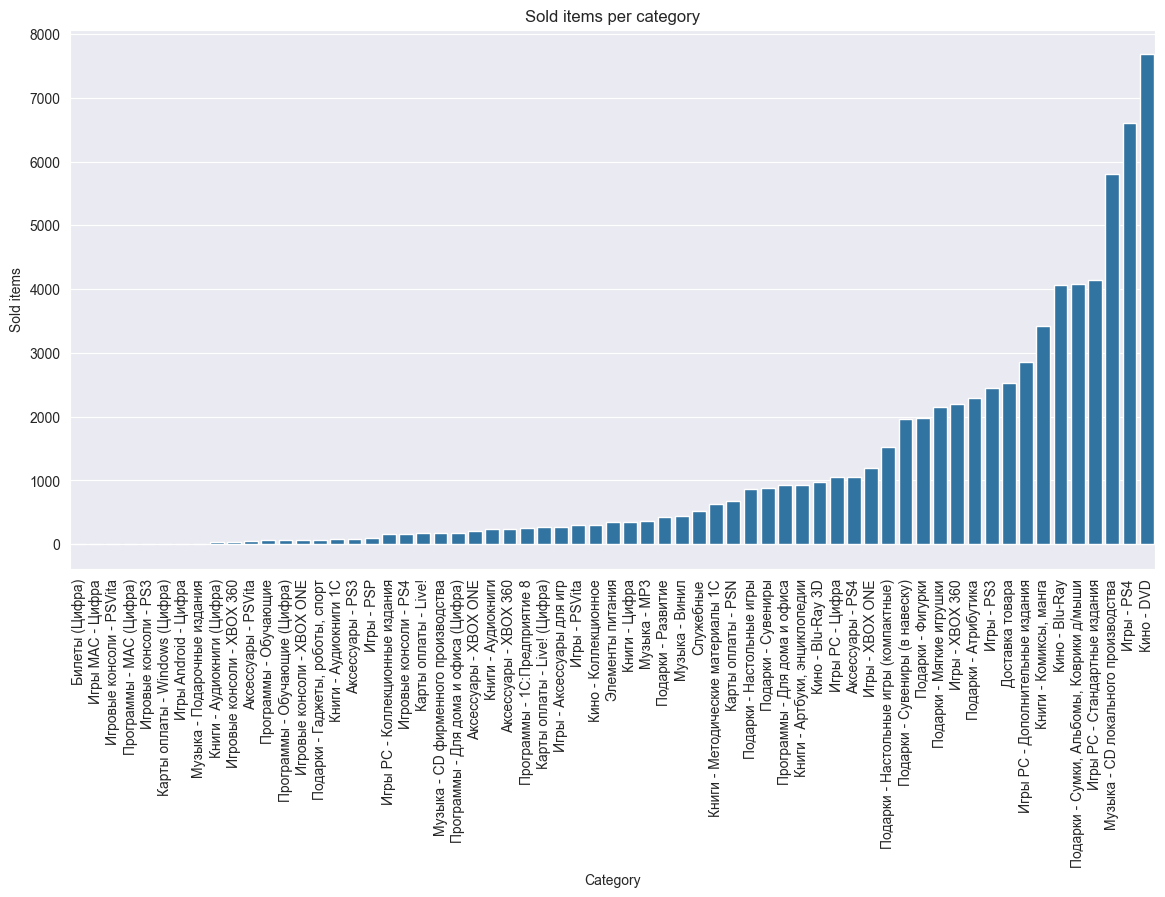

Top-10 categories:


,item_category_name,item_cnt_day
31,Кино - DVD,7680.0
13,Игры - PS4,6596.0
40,Музыка - CD локального производства,5808.0
23,Игры PC - Стандартные издания,4150.0
53,"Подарки - Сумки, Альбомы, Коврики д/мыши",4078.0
29,Кино - Blu-Ray,4061.0
37,"Книги - Комиксы, манга",3421.0
21,Игры PC - Дополнительные издания,2857.0
6,Доставка товара,2524.0
12,Игры - PS3,2443.0


In [12]:
month = 33
sales_per_category = df_train[df_train["date_block_num"] == month].groupby(["item_category_name"])["item_cnt_day"].sum().reset_index().sort_values("item_cnt_day")
plt.figure(figsize=(14,7))
plt.title("Sold items per category")
plt.xlabel("Category")
plt.ylabel("Sold items")
sns.barplot(data=sales_per_category, x="item_category_name", y="item_cnt_day")
plt.xticks(rotation=90)
plt.show()

print("Top-10 categories:")
sales_per_category.nlargest(10, columns="item_cnt_day")

The graph shows clear long-tail distribution, it means that there are some popular global categories like games and movis, but in the other hand there are some unpopular categories consoles or programs, I suggest to build at least 2 models to predict amount of goods, because one model will mostly learn patterns of popular categories, and will use this patterns to predict unpopular categories.

### Top and Bottom 5 shops sales

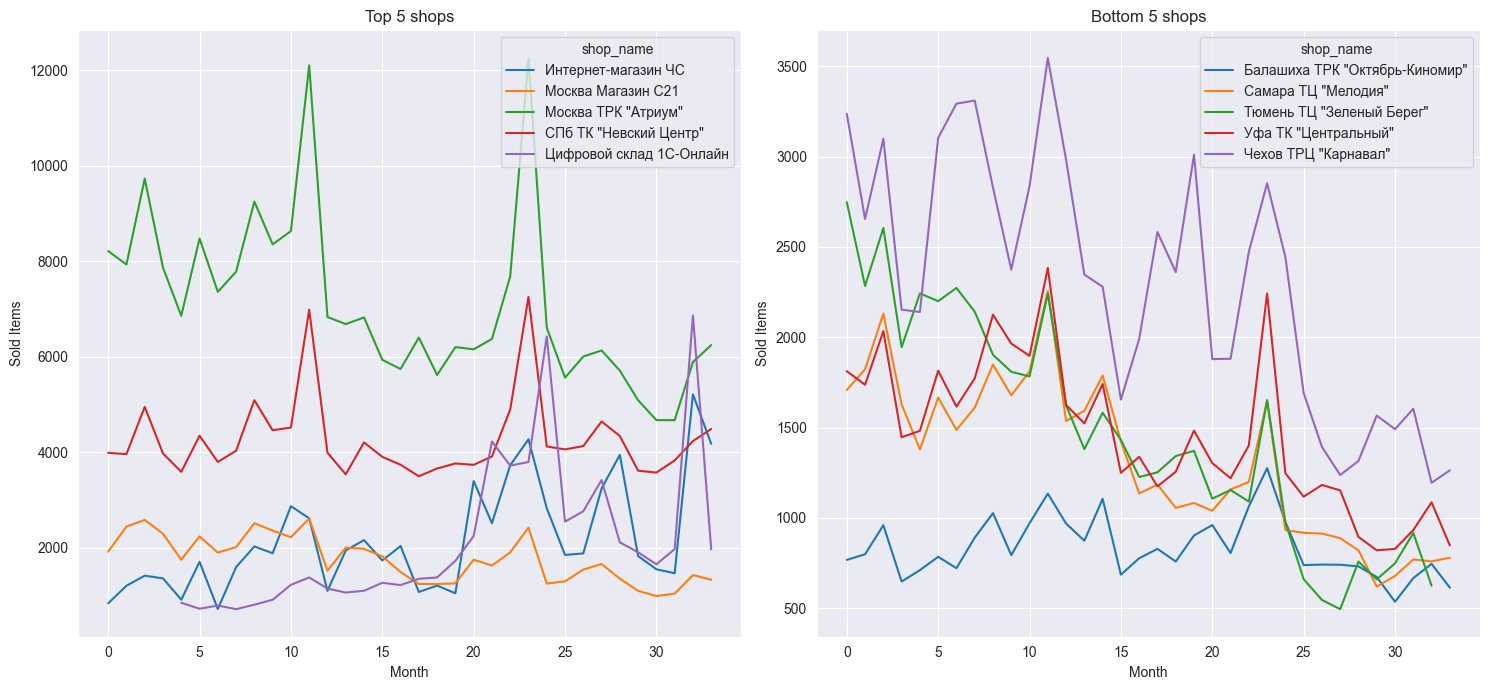

In [13]:
df_old_sales = df_train[df_train["shop_id"].isin(df_old_shops)]

period = 12
lower_bound = df_old_sales["date_block_num"].max() - period
df_period_sales = df_old_sales[df_old_sales["date_block_num"] >= lower_bound]
df_grouped_period_sales = df_period_sales.groupby("shop_id")["item_cnt_day"].mean().reset_index().sort_values("item_cnt_day")

top_5_shops = df_grouped_period_sales["shop_id"].tail(5).tolist()
bottom_5_shops = df_grouped_period_sales["shop_id"].head(5).tolist()

all_shop_sales_by_month = df_train.groupby(["shop_id", "date_block_num"])["item_cnt_day"].sum().reset_index()

all_shop_sales_by_month = all_shop_sales_by_month.merge(shops, how="left", on="shop_id", validate="m:1")

df_top_5 = all_shop_sales_by_month[all_shop_sales_by_month["shop_id"].isin(top_5_shops)]
df_bottom_5 = all_shop_sales_by_month[all_shop_sales_by_month["shop_id"].isin(bottom_5_shops)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

sns.lineplot(data=df_top_5, x="date_block_num", y="item_cnt_day", hue="shop_name", ax=ax[0])
ax[0].set_title("Top 5 shops")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Sold Items")

sns.lineplot(data=df_bottom_5, x="date_block_num", y="item_cnt_day", hue="shop_name", ax=ax[1])
ax[1].set_title("Bottom 5 shops")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Sold Items")

plt.tight_layout()
plt.show()

1. As we can see above Top 5 shops locate in big tows, while bottom 5 locate in tows with less population. So it's clear that sales depend on population of tows.
2. There are different types of shops, and it's clear that we cannot use same model to them. Via clustering find more similar shops, and use one model for each cluster. Also, clustering helps to find outliers, than we can learn separate model for each outlier.

### TOP-100 popular products for a month

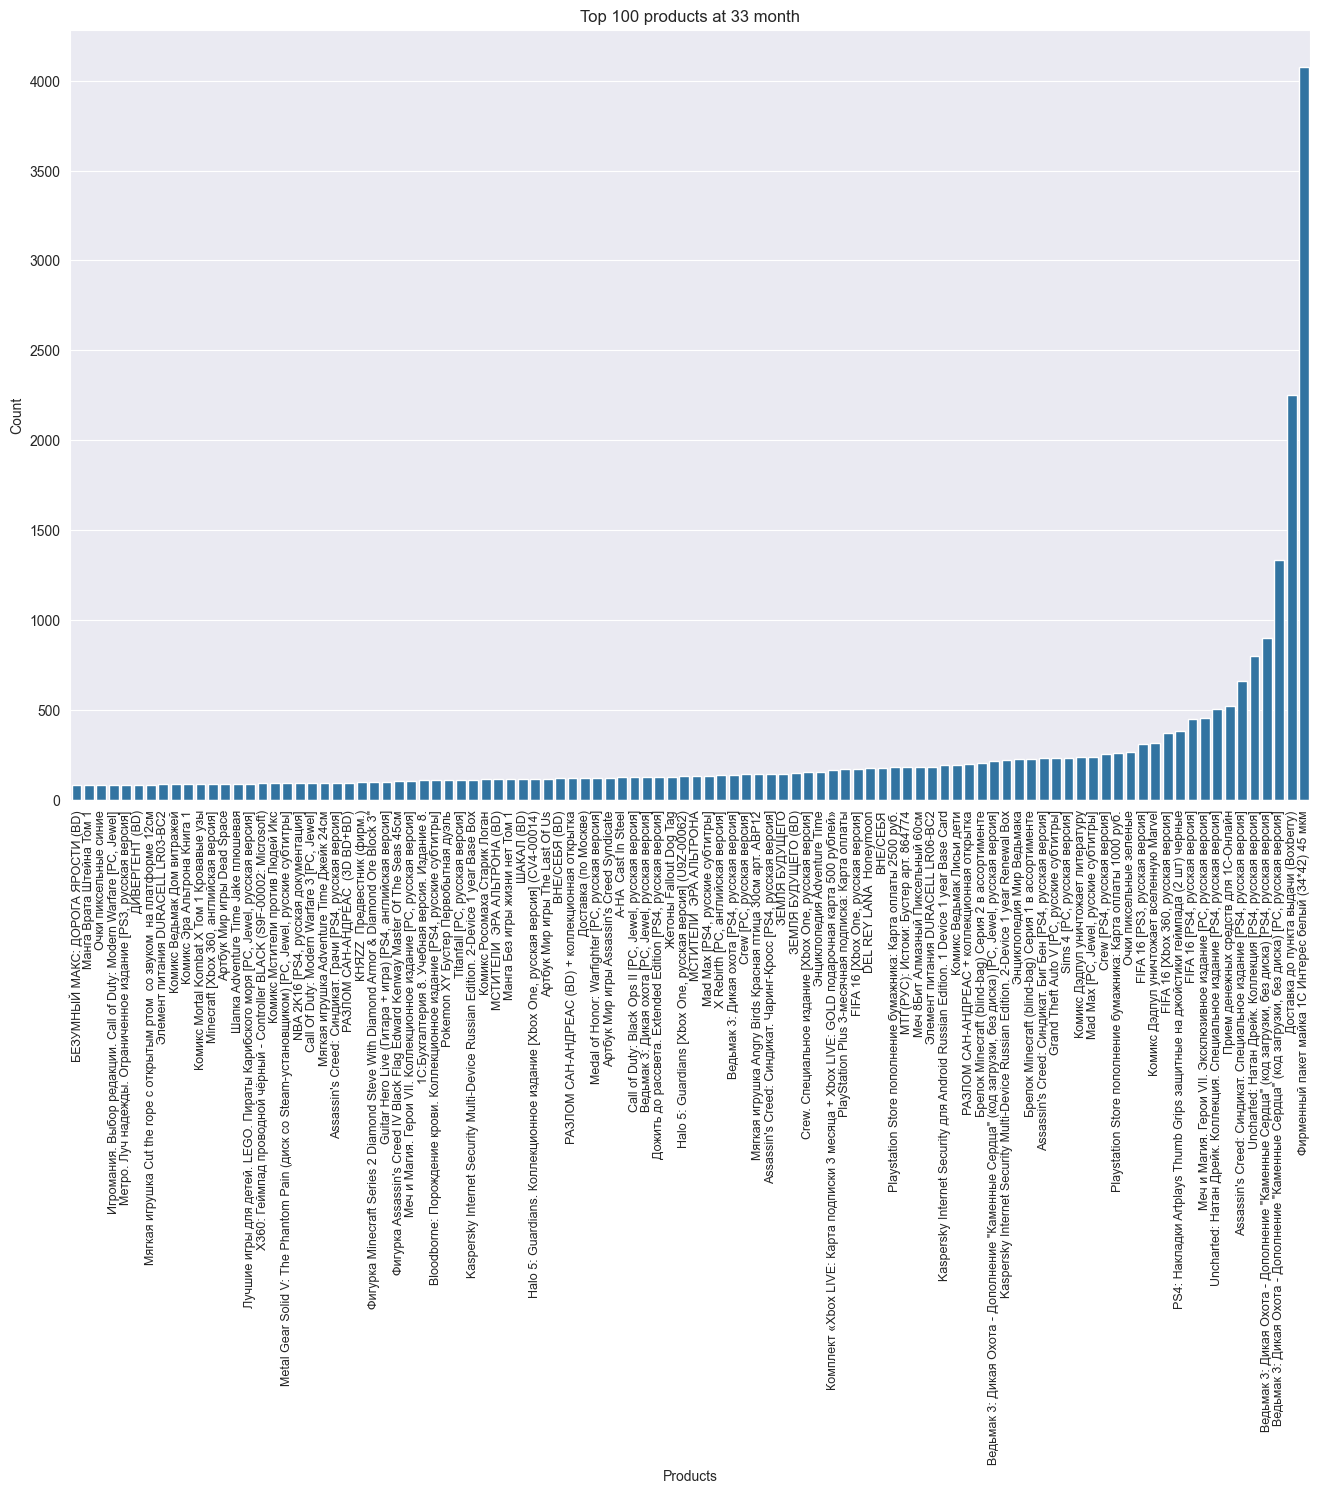

In [14]:
month = 33
top_100_products = df_train[df_train["date_block_num"] == month]
top_100_products = top_100_products.groupby(["date_block_num", "item_name"])["item_cnt_day"].sum().nlargest(100).reset_index()
top_100_products.sort_values(["item_cnt_day"], inplace=True)
plt.figure(figsize=(16, 10))
plt.title(f"Top 100 products at {month} month")
plt.xlabel("Products")
plt.ylabel("Count")
sns.barplot(data=top_100_products, x="item_name", y="item_cnt_day")
plt.xticks(rotation=90, fontsize=9)
plt.show()

The most popular good is "Фирменный пакет майка 1С Интерес белый", and amount of sold bunches greater than the second place almost on 2 times. So algorithm just will predict amount of bunches to predict the whole amount of supples.

### Trend, Seasonality, Irregular

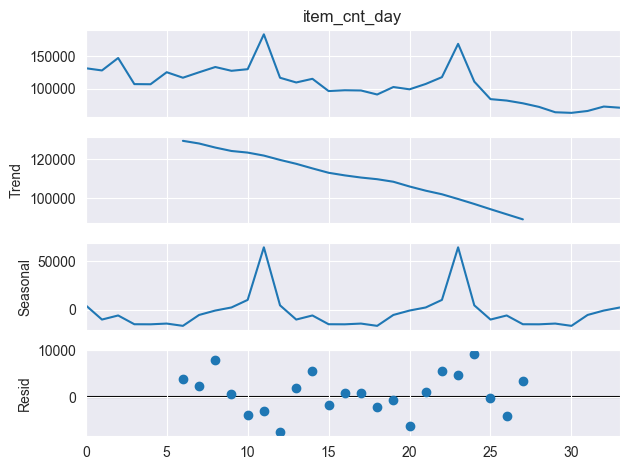

In [21]:
data_for_decomposition = pd.Series(monthly_sales["item_cnt_day"], index=monthly_sales["date_block_num"])
decomposition = seasonal_decompose(data_for_decomposition, model="add", period=12)
decomposition.plot()
plt.show()

1. Plot of trend shows downtrend, as I mentioned above distribution through the internet becomes more popular, and now we can add another one reason, but it's indirect consequences of the first reason, some shops closed, so it's clear that sales must decrease.
2. Seasonal plot shows clear seasonality during holiday period, it happens because people buy gifts.
3. It's difficult to say something about random component, because Irregular(Resid) plot shows almost equal amount of far and near points. To check Irregular component we should do Ljung-Box test.

### Ljung-Box test

In [22]:
test_result = acorr_ljungbox(decomposition.resid.dropna(), lags=12, return_df=True)
print("Ljung-box test result:")
test_result

Ljung-box test result:


,lb_stat,lb_pvalue
1,1.485633,0.222895
2,1.742243,0.418482
3,2.398263,0.493958
4,9.199771,0.056296
5,9.199842,0.101354
6,9.224833,0.161323
7,9.261135,0.234447
8,12.217337,0.141767
9,12.308470,0.196473
10,12.415391,0.258217


Ljung-Box test shows that there is one lag with low p-value, and it's 12-th lag. It's means that our data isn't white noise, and it's another evidence for year seasonality.

### Stationarity

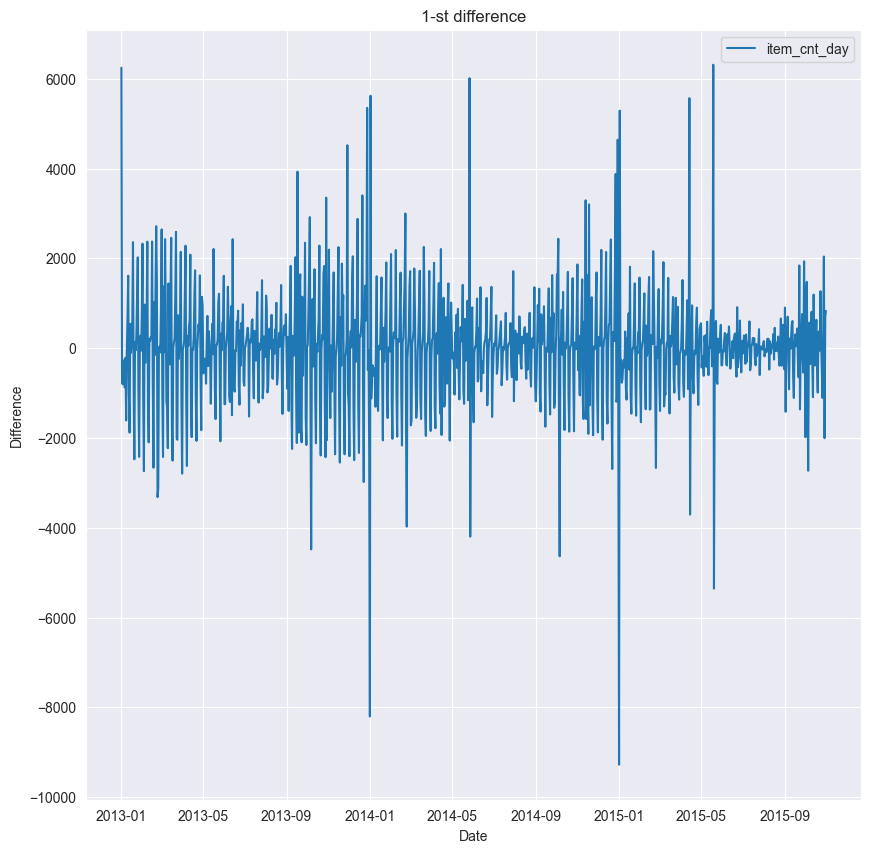

In [23]:
df_day_grouped = df_train.groupby("date")["item_cnt_day"].sum().reset_index().sort_values("date").set_index("date")
df_difference = df_day_grouped.diff().dropna()

plt.figure(figsize=(10,10))
plt.title("1-st difference")
plt.xlabel("Date")
plt.ylabel("Difference")
sns.lineplot(df_difference)
plt.show()

In [24]:
result = adfuller(df_difference)
print(f"p-value: {result[1]}")

p-value: 4.443836992716972e-15


1-st difference is stationary, It means that we can use models like SARIMA to predict amount of products.

### ACF and PACF

In [18]:
df_month = pd.DataFrame({"sales": monthly_sales["item_cnt_day"], "month": monthly_sales["date_block_num"]})
df_month.set_index("month", inplace=True)

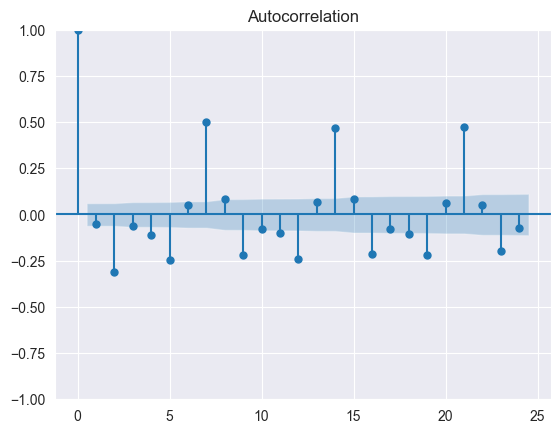

In [19]:
plot_acf(df_difference, lags=24)
None

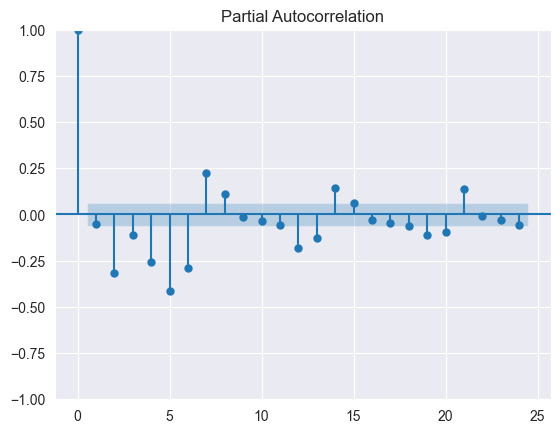

In [20]:
plot_pacf(df_difference, lags=24)
None

ACF and PACF plots don't have clear cutsoff or tailsoff patterns, so it's good idea to start from lower lag with bigger correlation for non-seasonal component. So based on this rule non-seasonal component has (6, 1, 2) parameters. Also, plots show clear seasonality at each 7-th lag, so it's a good idea to use SARIMA model with (1, 1, 1, 7) seasonal parameters.

## Preprocessing

1. Drop returns and its records with selling.
2. Move records where bunches were sold to another dataframe.
2. Drop duplicates.
3. Drop incorrect data.
4. Sort data by date index.
5. Drop shops that don't have enough history of sales (25 month) and shops that doesn't work in predicted month.
6. Use hierarchical clustering to find similar shops and outliers.

## Additional features

1. If we use model outside ARMA family, we can add column with 12-th lag to determine seasonality.
2. If we use model outside ARMA family, add some rolling features like average amount of products for last 3 month.

## Conclusion

- I decided to use SARIMA model with (6, 1, 2), for non-seasonal component and (1, 1, 1, 7) for seasonal component.
- I will cluster shops via hierarchical clustering and learn separate models for each cluster and outlier.
- I will build separate model for bunch prediction.